This file is to try SBI_SGM with new bounds 

And I train model with the individual connectomes.


### import and define

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Other pkgs

In [2]:
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")

#### My own pkgs

In [3]:
import importlib

from utils.misc import mag2db, meg_psd2spatialfeature, save_pkl_dict2folder, load_pkl_folder2dict, get_mode
from utils.misc import load_pkl, save_pkl
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from utils.brain_plot import U2BrainVec, reorderU 
from utils.reparam import theta_raw_2out, normcdf_np, normcdf_torch, logistic_np, logistic_torch
from utils.stable import paras_table_check
from sgm.sgm import SGM
from spectrome import Brain, path, functions
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT
from models.embedding_nets import SummaryNet

# import sgm.data_gen 
# importlib.reload(sgm.data_gen)
from sgm.data_gen import simulator_data

In [4]:
#torch.set_default_tensor_type(torch.DoubleTensor)

### Load real data PSD and brain

#### PSD and connectome

In [5]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

#### Set up Parameters

In [7]:
# some constant parameters for this file
paras = edict()
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (5, 20), (0.001,0.7), (0.001,2.0), (5.0,30.0))
#Bounds for taue, taui, alpha, speed, gei, gii, tauC
# (0.001,0.7), (0.001,2.0) when considering stable checking.
# (0.001,0.5), (0.001,1.5) as safe (narrower) bounds

# taue, taui, tauC, speed, alpha, gii, gei
paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]

paras.noise_sd = 1.20
paras.num_prior_sps = int(1e3)
paras.num_round = 2
paras.den_est = "nsf"
paras.is_embed = False

paras.prior_sd = 10

In [8]:
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

In [9]:
def _filter_unstable(theta_raw, prior_bds, x=None):
    """This fn is to remove unstable SGM parameters
        args: theta_raw: parameters: num of sps x dim
                order: ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei']
    """
    theta = _theta_raw_2out(theta_raw.numpy(), prior_bds)
    stable_idxs = paras_table_check(theta)
    
    # keep stable sps only
    theta_raw_stable = theta_raw[stable_idxs==0]
    if x is not None:
        x_stable = x[stable_idxs==0]
        return theta_raw_stable, x_stable
    else:
        return theta_raw_stable

In [10]:
# paras  for this file
_paras = edict()
_folder_path = f"./new_bds_reparam_MR_{paras.num_prior_sps:.0f}" +\
               f"_numround{paras.num_round:.0f}" +\
               f"_sd{paras.noise_sd*100:.0f}" +\
               f"_embed{paras.is_embed}"
_paras.folder_path = RES_ROOT/_folder_path
print(f"folder is {_paras.folder_path}")
print(_paras.folder_path.exists())

folder is /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse
False


In [11]:
cur_res = edict()

### Prepare for SBI

#### Simulator

In [12]:
def simulator(params, noise_sd, sgmmodel, prior_bds):
    """The function to simulate samples
    """
    params_trans = []
    for param, prior_bd in zip(params, prior_bds):
        param_trans =  _map_fn_torch(param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params_trans.append(param_trans)
    params_trans = torch.tensor(params_trans)
    
    psd, spatialFs = sgmmodel.run_local_coupling_forward(params_trans)
    psd = psd[:68, :]
    std_spatial = stdz_vec(spatialFs.sum(axis=1)) # std it
    
    std_psd_DB = psd_2tr(psd)
    psd_fs = std_psd_DB.flatten()
    
    res = np.concatenate([psd_fs, std_spatial]) 
    noise =  np.random.randn(*res.shape)*noise_sd 
    
    return res+noise

#### Prior 

In [13]:
prior = MultivariateNormal(loc=torch.zeros(7), covariance_matrix=torch.eye(7)*(paras.prior_sd**2))

#### Density estimator

In [14]:
if paras.is_embed:
    embedding_net = SummaryNet(num_in_fs=68*41)
    paras.den_est = sutils.posterior_nn(
    model=paras.den_est, embedding_net=embedding_net)
    for ix in embedding_net.parameters():
        print(ix.sum(), ix.shape, ix.dtype)

### SBI

#### RUN

In [15]:
# obtain the brain
for ix in range(0, ind_psd.shape[-1]):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    # the simulator
    sgmmodel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
    simulator_sp = partial(simulator,  
                           noise_sd=paras.noise_sd, 
                           sgmmodel=sgmmodel,
                           prior_bds=paras.prior_bds)
    # make a SBI-wrapper on the simulator object for compatibility
    simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)
    
    # the observed data
    sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, 
                                         ind_psd[:, :, ix], FREQS, 
                                         band="alpha")
    std_spv = stdz_vec(raw_sps.sum(axis=1))
    std_psd_DB = psd_2tr(ind_psd[:, :, ix])
    
    curX_raw = np.concatenate([std_psd_DB.flatten(), std_spv])
    curX = torch.Tensor(curX_raw)


    if paras.is_embed:
        # embedding net
        cur_embedding_net = SummaryNet(num_in_fs=516)
        cur_den_est = sutils.posterior_nn(
        model=paras.den_est, embedding_net=cur_embedding_net)
        #for iy in embedding_net.parameters():
        #    print(iy.sum(), iy.shape)
    else:
        cur_den_est = paras.den_est
    
    inference = SNPE(prior=prior, 
                     density_estimator=cur_den_est)
    proposal = prior 
    for _ in range(paras.num_round):
        theta_raw, x = simulate_for_sbi(simulator_wrapper, proposal,
                                    num_simulations=paras.num_prior_sps, 
                                    num_workers=50)
        theta_raw_stable, x_stable = _filter_unstable(theta_raw, paras.prior_bds, x)
        density_estimator = inference.append_simulations(
                            theta_raw_stable, x_stable, proposal=proposal
                            ).train()
        posterior = inference.build_posterior(density_estimator)
        
        
        #update proposal 
        proposal = posterior.set_default_x(curX)
        
    cur_res[f"posterior_{ix+1}"] = posterior
    cur_res[f"posteriorfix_{ix+1}"] = proposal
    if paras.is_embed:
        cur_res[f"embedding_net_{ix+1}"] = cur_embedding_net
    save_pkl_dict2folder(_paras.folder_path, cur_res)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse
Create a folder /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../result

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 26 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 22 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 26 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 28 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 26 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Neural network successfully converged after 23 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_24.pkl


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_25.pkl


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posterior_3.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyRese

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_26.pkl


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Get posterior

In [16]:
cur_res = edict()
post_fils = list(_paras.folder_path.glob("*fix_*.pkl"))
sorted_post_fils = sorted(post_fils, key=lambda x: int(x.stem.split("_")[-1]))

In [17]:
post_spss_raw = []
for ix in range(ind_psd.shape[-1]):
    cur_posterior = load_pkl(sorted_post_fils[ix])
    
    post_sps_raw = cur_posterior.sample((10000, ), max_sampling_batch_size=100000)
    post_sps_raw_stable = _filter_unstable(post_sps_raw, paras.prior_bds)
    post_spss_raw.append(post_sps_raw_stable.numpy())
        

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_1.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_2.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_3.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_4.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_5.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_6.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_7.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_8.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_9.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_10.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_11.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_12.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_13.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_14.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_15.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_16.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_17.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_18.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_19.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_20.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_21.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_22.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_23.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_24.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_25.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_26.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_27.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_28.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_29.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_30.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_31.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_32.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_33.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_34.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_35.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/posteriorfix_36.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
cur_res.post_spss_raw = post_spss_raw
save_pkl_dict2folder(_paras.folder_path, cur_res, is_force=False)

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/post_spss_raw.pkl


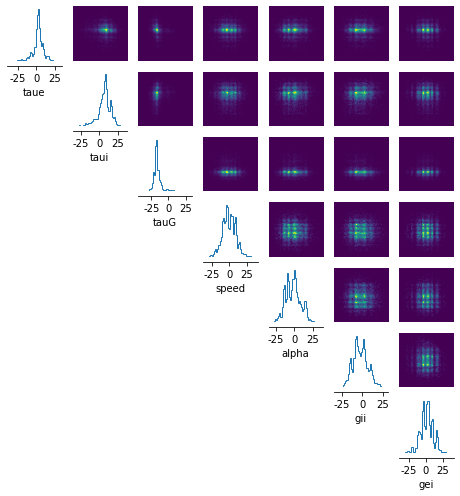

In [19]:
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(cur_res.post_spss_raw[0], 
                      #limits=paras.prior_bds,
                      labels=['taue','taui','tauG','speed','alpha','gii','gei'], 
                      figsize=(8,8))

In [20]:
# from theta_raw to theta
post_spss = [_theta_raw_2out(post_sps_raw, paras.prior_bds) for post_sps_raw in cur_res.post_spss_raw]

cur_res.post_spss = post_spss
save_pkl_dict2folder(_paras.folder_path, cur_res, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/post_spss_raw.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/post_spss.pkl


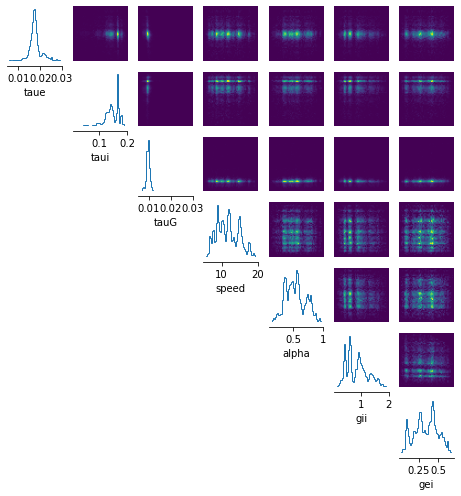

In [22]:
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(cur_res.post_spss[1], 
                      limits=paras.prior_bds,
                      labels=['taue','taui','tauG','speed','alpha','gii','gei'], 
                      figsize=(8,8))

#### PSD estimate

In [23]:
cur_res = load_pkl_folder2dict(_paras.folder_path, ["x", "posterior*"])

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/post_spss_raw.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd120_embedFalse/post_spss.pkl


In [24]:
# the estimated PSD and spatial feature from SGM  

# way 1
cur_est_parass = np.array([np.median(ps, axis=0) for ps in cur_res.post_spss])

# way 2
#cur_est_parass = np.array([[get_mode(ps[:, ix]) for ix in range(7)] for ps in cur_res.post_spss])

# way 3
#cur_est_parass_raw = np.array([np.median(ps, axis=0) for ps in cur_res.post_spss_raw])
#cur_est_parass = _theta_raw_2out(cur_est_parass_raw, paras.prior_bds)

# way 4
#cur_est_parass_raw = np.array([[get_mode(ps[:, ix]) for ix in range(7)] for ps in cur_res.post_spss_raw])
#cur_est_parass = _theta_raw_2out(cur_est_parass_raw, paras.prior_bds)

std_psd_DB = []
raw_sp = []
for ix in trange(36):
    cur_est_paras = cur_est_parass[ix, :]
    
    cur_conn = ind_conn[:, :, ix]
    cur_brain = Brain.Brain()
    cur_brain.add_connectome(DAT_ROOT) # grabs distance matrix
    cur_brain.reorder_connectome(cur_brain.connectome, cur_brain.distance_matrix)
    cur_brain.connectome = cur_conn# re-assign connectome to individual connectome
    cur_brain.bi_symmetric_c()
    cur_brain.reduce_extreme_dir()
    
    cur_SGM_model = SGM(cur_brain.reducedConnectome, cur_brain.distance_matrix, FREQS)
    cur_psd, cur_sp = cur_SGM_model.run_local_coupling_forward(cur_est_paras)
    cur_psd = cur_psd[:68, :]
    cur_psd_DB = psd_2tr(cur_psd)
    
    std_psd_DB.append(cur_psd_DB)
    raw_sp.append(cur_sp.sum(axis=1))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


In [25]:
sgm_psd_curve = np.array(std_psd_DB).mean(axis=1).mean(axis=0)
meg_psd_curve = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
cor = scipy.stats.pearsonr(stdz_vec(meg_psd_curve), stdz_vec(sgm_psd_curve))[0]
print(f"Corr is {cor:.3f}")

Corr is 0.980


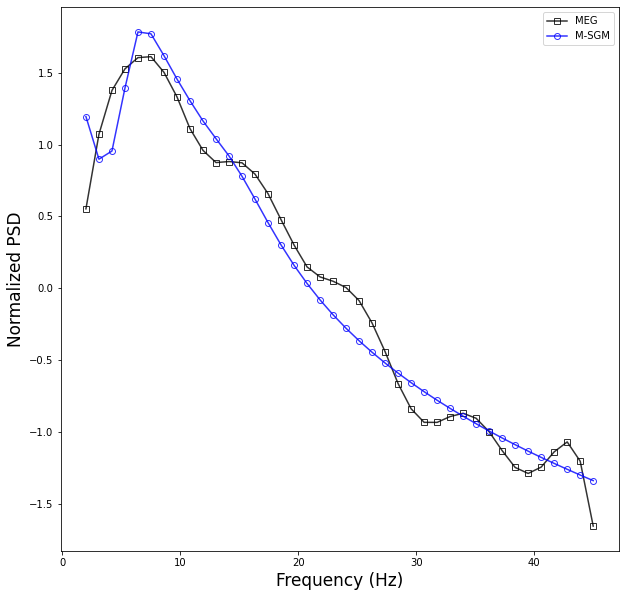

In [26]:
plt.figure(figsize=[10, 10])
#plt.plot(FREQS, meg_psd_curve, linestyle = '-',
plt.plot(FREQS, stdz_vec(meg_psd_curve), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
#plt.plot(FREQS, sgm_psd_curve, linestyle = '-',
plt.plot(FREQS, stdz_vec(sgm_psd_curve), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

In [27]:
# Corrs for PSD and spatial features for each subject
meg_psd_roi_sub = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])
sgm_psd_roi_sub = np.array(std_psd_DB)

corrs_roi_sub = []
for ix in range(meg_psd_roi_sub.shape[0]):
    cur_meg = meg_psd_roi_sub[ix]
    cur_sgm = sgm_psd_roi_sub[ix]
    corrs_roi_sub.append(np.mean([scipy.stats.pearsonr(cur_meg[iy], cur_sgm[iy])[0] for iy in range(68)]))
corrs_roi_sub = np.array(corrs_roi_sub)

In [28]:
np.sort(corrs_roi_sub)

array([0.76063128, 0.80245997, 0.80316068, 0.83603697, 0.84713347,
       0.85849184, 0.86097573, 0.86277933, 0.87190826, 0.87210961,
       0.87268641, 0.87651165, 0.87675397, 0.87774809, 0.8783596 ,
       0.88054755, 0.88158385, 0.88373802, 0.88557724, 0.88594906,
       0.89008301, 0.8901522 , 0.890153  , 0.89021208, 0.89827378,
       0.89879037, 0.9008039 , 0.90392965, 0.90584064, 0.90931671,
       0.90948463, 0.90973105, 0.91011947, 0.91046547, 0.91140446,
       0.93083753])

In [29]:
print(np.median(corrs_roi_sub), np.mean(corrs_roi_sub))

0.8846576336998409 0.8787427926269182


In [30]:
np.argsort(corrs_roi_sub)

array([24,  4, 32, 21, 11, 18, 25,  3, 28, 34, 10,  9, 14,  7,  1, 31,  0,
       15,  2, 17, 35,  8, 19, 30, 33, 27, 22, 16, 26, 12, 23, 13,  5,  6,
       20, 29])

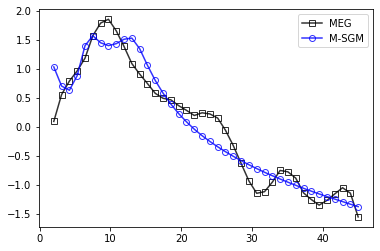

In [31]:
sub_ix = 1
cur_sgm.shape
plt.plot(FREQS, stdz_vec(meg_psd_roi_sub[sub_ix, :, :].mean(axis=0)), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, stdz_vec(sgm_psd_roi_sub[sub_ix, :, :].mean(axis=0)), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()

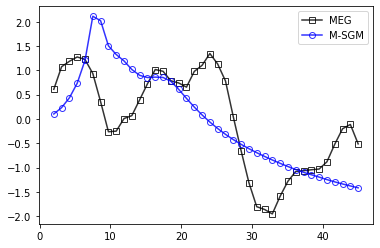

In [45]:
sub_ix = 24
roi_ix = 1
cur_sgm.shape
plt.plot(FREQS, stdz_vec(meg_psd_roi_sub[sub_ix, roi_ix, :]), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, stdz_vec(sgm_psd_roi_sub[sub_ix, roi_ix, :]), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()

In [32]:
cur_res.raw_sp = raw_sp
cur_res.std_psd_DB = std_psd_DB
save_pkl_dict2folder(_paras.folder_path, cur_res, False)

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/theta_raw.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/x.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/posterior.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/embedding_net.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/post_spss_raw.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/post_spss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/generalNoiseRawReparam_20000_sd20_denestnsf_embedTrue/raw_sp.pkl
Save to /data/rajlab1/u

### Another way to do the inference

In [31]:
all_post_psds = []
for ix in range(ind_psd.shape[-1]):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    cur_sgmmodel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
        
    cur_post = load_pkl(sorted_post_fils[ix])
        
    simulator_data_sp = partial(simulator_data,  sgmmodel=cur_sgmmodel, prior_bds=paras.prior_bds)
    simulator_data_wrapper, _ = prepare_for_sbi(simulator_data_sp, prior)
    
    tmp_sps, post_psd = simulate_for_sbi(simulator_data_wrapper, cur_post, 
                            num_simulations=1000,
                            num_workers=50)
    _, post_psd_stable = _filter_unstable(tmp_sps, paras.prior_bds, post_psd)
    print(ix, post_psd_stable.shape)
    all_post_psds.append(post_psd_stable.numpy())

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_1.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

0 torch.Size([997, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_2.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

1 torch.Size([987, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_3.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

2 torch.Size([978, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_4.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

3 torch.Size([978, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_5.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

4 torch.Size([997, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_6.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

5 torch.Size([867, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_7.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

6 torch.Size([954, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_8.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

7 torch.Size([997, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_9.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

8 torch.Size([584, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_10.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

9 torch.Size([424, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_11.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

10 torch.Size([555, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_12.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

11 torch.Size([605, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_13.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

12 torch.Size([208, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_14.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

13 torch.Size([963, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_15.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

14 torch.Size([931, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_16.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

15 torch.Size([989, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_17.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

16 torch.Size([484, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_18.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

17 torch.Size([972, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_19.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

18 torch.Size([740, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_20.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

19 torch.Size([498, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_21.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

20 torch.Size([987, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_22.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

21 torch.Size([999, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_23.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

22 torch.Size([999, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_24.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

23 torch.Size([909, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_25.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

24 torch.Size([998, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_26.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

25 torch.Size([909, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_27.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

26 torch.Size([972, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_28.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

27 torch.Size([991, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_29.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

28 torch.Size([996, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_30.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

29 torch.Size([981, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_31.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

30 torch.Size([884, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_32.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

31 torch.Size([998, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_33.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

32 torch.Size([147, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_34.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

33 torch.Size([908, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_35.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

34 torch.Size([988, 2788])
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/new_bds_reparam_MR_1000_numround2_sd20_embedFalse/posteriorfix_36.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

35 torch.Size([993, 2788])


In [29]:
est_psds = []
for post_psd in all_post_psds:
    est_psd = np.mean(post_psd[:, :-68], axis=0)
    est_psd = est_psd.reshape(68, 40)
    est_psds.append(est_psd)

In [30]:
sgm_psd_curve1 = np.array(est_psds).mean(axis=1).mean(axis=0)
meg_psd_curve = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
cor = scipy.stats.pearsonr(stdz_vec(meg_psd_curve), stdz_vec(sgm_psd_curve1))[0]
print(f"Corr is {cor:.3f}")

Corr is 0.991


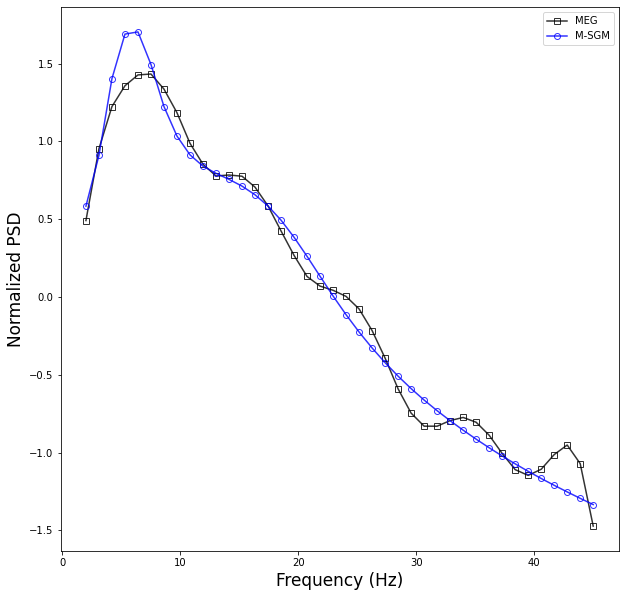

In [31]:
plt.figure(figsize=[10, 10])
plt.plot(FREQS, meg_psd_curve, linestyle = '-',
#plt.plot(FREQS, stdz_vec(meg_psd_curve), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, sgm_psd_curve1, linestyle = '-',
#plt.plot(FREQS, stdz_vec(sgm_psd_curve1), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

In [32]:
# Corrs for PSD and spatial features for each subject
meg_psd_roi_sub = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])
sgm_psd_roi_sub = np.array(est_psds)

corrs_roi_sub1 = []
for ix in range(meg_psd_roi_sub.shape[0]):
    cur_meg = meg_psd_roi_sub[ix]
    cur_sgm = sgm_psd_roi_sub[ix]
    corrs_roi_sub1.append(np.mean([scipy.stats.pearsonr(cur_meg[iy], cur_sgm[iy])[0] for iy in range(68)]))
corrs_roi_sub1 = np.array(corrs_roi_sub1)

In [33]:
print(np.median(corrs_roi_sub1), np.mean(corrs_roi_sub1))

0.8996274512315984 0.886413932687284


In [34]:
np.sort(corrs_roi_sub1)

array([0.79015653, 0.81367861, 0.82752168, 0.83531536, 0.84630147,
       0.84936092, 0.85593023, 0.86094853, 0.86212447, 0.86857638,
       0.87321716, 0.8770834 , 0.87837815, 0.88254927, 0.88757868,
       0.88765754, 0.89439217, 0.89804665, 0.90120826, 0.90176411,
       0.90239248, 0.9026675 , 0.90271349, 0.90273594, 0.90365148,
       0.90575111, 0.90627142, 0.90874934, 0.91172765, 0.91250269,
       0.91570805, 0.91683261, 0.92314986, 0.92403283, 0.9392772 ,
       0.94094836])

In [35]:
np.argsort(corrs_roi_sub1)

array([24,  4, 21, 32, 18,  1, 25, 33,  3, 11,  7, 34,  0,  9, 16, 14, 27,
       17, 10, 22, 13, 23, 28, 15, 19, 31, 35,  8, 12, 26,  5,  6,  2, 20,
       30, 29])

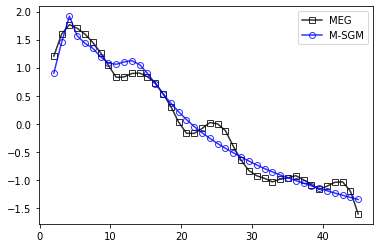

In [36]:
ix = 30 
sgm_post_rois = sgm_psd_roi_sub.mean(axis=1)
plt.plot(FREQS, stdz_vec(meg_psd_roi_sub[ix, :, :].mean(axis=0)), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, stdz_vec(sgm_post_rois[ix]), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()